In [114]:
import os
import json
import boto3
import torch
import torchvision
from PIL import Image
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights

import tempfile

I found jumpstart to be too restrictive in the end, SSDlite_mobilenet V3 is an object detection model which is available in jumpstart.
With some help from GPT I loaded that same model in this notebook for finetuning

In [122]:
class LemonCocoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        with open(annotation_file, 'r') as f:
            self.coco = json.load(f)
        self.image_id_to_info = {img["id"]: img for img in self.coco["images"]}
        self.annotations_by_image = {}
        for ann in self.coco["annotations"]:
            self.annotations_by_image.setdefault(ann["image_id"], []).append(ann)
        self.image_ids = list(self.image_id_to_info.keys())
        self.cat_id_to_name = {cat["id"]: cat["name"] for cat in self.coco["categories"]}

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_info = self.image_id_to_info[image_id]
        img_path = os.path.join(self.root_dir, img_info["file_name"])
        image = Image.open(img_path).convert("RGB")
        ann_list = self.annotations_by_image.get(image_id, [])
        boxes = [[x, y, x + w, y + h] for x, y, w, h in [ann["bbox"] for ann in ann_list]]
        labels = [ann["category_id"] for ann in ann_list]
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([image_id])}
        if self.transforms: image = self.transforms(image)
        if boxes.shape[0] == 0:
            raise ValueError(f"No annotations for image_id {image_id}")
        return image, target

def create_model(num_classes):
    weights = SSDLite320_MobileNet_V3_Large_Weights.DEFAULT
    model = ssdlite320_mobilenet_v3_large(weights=weights)
    num_anchors = 6
    new_out_channels = num_anchors * num_classes
    for i, seq in enumerate(model.head.classification_head.module_list):
        in_channels = seq[1].in_channels
        kernel_size = seq[1].kernel_size
        padding = seq[1].padding
        new_conv = torch.nn.Conv2d(in_channels, new_out_channels, kernel_size, stride=1, padding=padding)
        torch.nn.init.normal_(new_conv.weight, mean=0.0, std=0.01)
        torch.nn.init.constant_(new_conv.bias, 0)
        model.head.classification_head.module_list[i][1] = new_conv
    model.head.classification_head.num_classes = num_classes
    model.head.classification_head.num_columns = num_classes
    return model

def collate_fn(batch):
    return tuple(zip(*batch))

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    total_loss = 0.0
    for i, (images, targets) in enumerate(data_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if (i + 1) % print_freq == 0:
            print(f"Epoch [{epoch}], Iteration [{i+1}], Loss: {loss.item():.4f}")
    print(f"Epoch {epoch} completed, Avg Loss: {total_loss / len(data_loader):.4f}")


# S3 upload helper for checkpoints
def upload_to_s3(local_path, bucket, key):
    s3 = boto3.client('s3')
    s3.upload_file(local_path, bucket, key)
    print(f"Uploaded {local_path} to s3://{bucket}/{key}")

Download data from S3 to local instance

In [ ]:
BUCKET = "lemonproject"
TRAIN_JSON_S3 = "image_subset/train/annotations.json"
TRAIN_IMAGES_S3 = "image_subset/train/images"
LOCAL_DATA_DIR = "lemon_local_train"
LOCAL_IMG_DIR = os.path.join(LOCAL_DATA_DIR, "images")
LOCAL_JSON = os.path.join(LOCAL_DATA_DIR, "annotations.json")

# Make local dirs
os.makedirs(LOCAL_IMG_DIR, exist_ok=True)

# Download JSON from S3
s3 = boto3.client('s3')
s3.download_file(BUCKET, TRAIN_JSON_S3, LOCAL_JSON)


with open(LOCAL_JSON, 'r') as f:
    data = json.load(f)


for img in data["images"]:
   
    fname = img["file_name"]
    #print(f"Trying to download: s3://{BUCKET}/{fname}")
    s3.download_file(BUCKET, f"{TRAIN_IMAGES_S3}/{fname}", os.path.join(LOCAL_IMG_DIR, fname))
# === Config for test set ===
BUCKET = "lemonproject"
TEST_JSON_S3 = "image_subset/test/annotations.json"
TEST_IMAGES_S3 = "image_subset/test/images"
LOCAL_TEST_DIR = "lemon_local_test"
LOCAL_TEST_IMG_DIR = os.path.join(LOCAL_TEST_DIR, "images")
LOCAL_TEST_JSON = os.path.join(LOCAL_TEST_DIR, "annotations.json")


os.makedirs(LOCAL_TEST_IMG_DIR, exist_ok=True)


s3 = boto3.client("s3")
s3.download_file(BUCKET, TEST_JSON_S3, LOCAL_TEST_JSON)
print(f"* Downloaded {TEST_JSON_S3} to {LOCAL_TEST_JSON}")


with open(LOCAL_TEST_JSON, 'r') as f:
    data = json.load(f)


for img in data["images"]:
    fname = img["file_name"]
    print(f"Downloading: s3://{BUCKET}/{TEST_IMAGES_S3}/{fname}")
    s3.download_file(BUCKET, f"{TEST_IMAGES_S3}/{fname}", os.path.join(LOCAL_TEST_IMG_DIR, fname))

This next bit here keeps only the "mould" annotations for the training data, the annotations for the other classes were done sloppily and were not learnable (even for me, I had difficulty understanding the reasoning just looking at them). Also there were some extremely tiny bounding boxes which weren't learnable either, filtered those with an area less than 50 pixels out. The filtering step may be redundant as we filter in the train test split anyways, but when I first wrote this that wasn't the case.

In [119]:
bucket = "lemonproject"
json_key = "image_subset/train/annotations.json"
local_file = "lemon_local_train/annotations.json" 


s3 = boto3.client("s3")
s3.download_file(bucket, json_key, local_file)
print(f"* Downloaded {json_key} → {local_file}")


with open(local_file, "r") as f:
    data = json.load(f)

# === Filter to 'mould' with area > 50
target_classes = {"mould"}
class_name_to_id = {cat["name"]: cat["id"] for cat in data["categories"]}
target_class_ids = {class_name_to_id[name] for name in target_classes if name in class_name_to_id}
print(f"* Keeping: {target_classes} → IDs: {sorted(target_class_ids)}")

data["annotations"] = [
    ann for ann in data["annotations"]
    if ann["category_id"] in target_class_ids and ann["bbox"][2] * ann["bbox"][3] > 50
]

# Strip prefix from filenames, causes issues later on
for img in data["images"]:
    img["file_name"] = os.path.basename(img["file_name"])

# Keep only used images & categories
used_image_ids = {ann["image_id"] for ann in data["annotations"]}
data["images"] = [img for img in data["images"] if img["id"] in used_image_ids]
used_cat_ids = {ann["category_id"] for ann in data["annotations"]}
data["categories"] = [cat for cat in data["categories"] if cat["id"] in used_cat_ids]

#Reindex for training, as the model expects 0,1,2 etc and mould is ID 4 
sorted_cats = sorted(data["categories"], key=lambda x: x["name"])
old_to_new = {cat["id"]: new_id for new_id, cat in enumerate(sorted_cats)}

for ann in data["annotations"]:
    ann["category_id"] = old_to_new[ann["category_id"]]
for cat in data["categories"]:
    cat["id"] = old_to_new[cat["id"]]


with open(local_file, "w") as f:
    json.dump(data, f)
s3.upload_file(local_file, bucket, json_key)

#sanity check
cat_ids = sorted(set(ann["category_id"] for ann in data["annotations"]))
print(f"\n* Cleaned & reindexed → category_ids in annotations: {cat_ids}")
for cat in data["categories"]:
    print(f"  id: {cat['id']} → name: {cat['name']}")
print(f"* Uploaded back to: s3://{bucket}/{json_key}")

* Downloaded image_subset/train/annotations.json → lemon_local_train/annotations.json
* Keeping: {'mould'} → IDs: [0]

* Cleaned & reindexed → category_ids in annotations: [0]
  id: 0 → name: mould
* Uploaded back to: s3://lemonproject/image_subset/train/annotations.json


# Training

In [133]:
BUCKET = "lemonproject"
CHECKPOINT_LOCAL_PATH = "checkpoint.pth"
CHECKPOINT_S3_KEY = "image_subset/checkpoints/checkpoint_v2.pth"

# === Download checkpoint from S3
s3 = boto3.client('s3')
s3.download_file(BUCKET, CHECKPOINT_S3_KEY, CHECKPOINT_LOCAL_PATH)
print(f"* Downloaded checkpoint from s3://{BUCKET}/{CHECKPOINT_S3_KEY}")

# === Dataset and DataLoader
transform = torchvision.transforms.ToTensor()
dataset = LemonCocoDataset(root_dir=LOCAL_IMG_DIR, annotation_file=LOCAL_JSON, transforms=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn, drop_last=True)

# === Setup model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(num_classes=2).to(device)
optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad],
                            lr=0.0005, momentum=0.9, weight_decay=0.0005)

# === Load checkpoint
checkpoint = torch.load(CHECKPOINT_LOCAL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
start_epoch = checkpoint["epoch"] + 1
print(f"* Resuming from epoch {start_epoch}")

# === Training loop (20 more epochs)
for epoch in range(start_epoch, start_epoch + 20):
    train_one_epoch(model, optimizer, data_loader, device, epoch)

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, CHECKPOINT_LOCAL_PATH)

    # Upload to S3
    s3.upload_file(CHECKPOINT_LOCAL_PATH, BUCKET, CHECKPOINT_S3_KEY)
    print(f"* Saved and uploaded checkpoint for epoch {epoch}")

* Downloaded checkpoint from s3://lemonproject/image_subset/checkpoints/checkpoint_v2.pth


/tmp/ipykernel_6362/3723648643.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_LOCAL_PATH, map_location=device)


* Resuming from epoch 10
Epoch [10], Iteration [10], Loss: 0.0466
Epoch [10], Iteration [20], Loss: 0.1290
Epoch 10 completed, Avg Loss: 0.1064
* Saved and uploaded checkpoint for epoch 10
Epoch [11], Iteration [10], Loss: 0.0765
Epoch [11], Iteration [20], Loss: 0.0707
Epoch 11 completed, Avg Loss: 0.0999
* Saved and uploaded checkpoint for epoch 11
Epoch [12], Iteration [10], Loss: 0.0970
Epoch [12], Iteration [20], Loss: 0.0520
Epoch 12 completed, Avg Loss: 0.0889
* Saved and uploaded checkpoint for epoch 12
Epoch [13], Iteration [10], Loss: 0.0320
Epoch [13], Iteration [20], Loss: 0.0425
Epoch 13 completed, Avg Loss: 0.0840
* Saved and uploaded checkpoint for epoch 13
Epoch [14], Iteration [10], Loss: 0.0400
Epoch [14], Iteration [20], Loss: 0.0514
Epoch 14 completed, Avg Loss: 0.0806
* Saved and uploaded checkpoint for epoch 14
Epoch [15], Iteration [10], Loss: 0.0925
Epoch [15], Iteration [20], Loss: 0.0605
Epoch 15 completed, Avg Loss: 0.0603
* Saved and uploaded checkpoint for 

# Model Eval

In [164]:
from torchvision.ops import box_iou

model.eval()
score_threshold = 0.69 # confidence 
iou_threshold = 0.4

tp, fp, fn = 0, 0, 0
checked = 0

for i in range(len(test_dataset)):
    image, target = test_dataset[i]
    
    # Grab all GT mould boxes (label 4 in test annotations)
    gt_boxes = target["boxes"][target["labels"] == 4].to(device)
    checked += 1

    with torch.no_grad():
        pred = model([image.to(device)])[0]

    # Grab predicted boxes for mould, label 1 output for model 
    keep = (pred["labels"] == 1) & (pred["scores"] >= score_threshold)
    pred_boxes = pred["boxes"][keep].to(device)



    if len(pred_boxes) == 0 and len(gt_boxes) > 0:
        fn += len(gt_boxes)
        continue
    if len(gt_boxes) == 0 and len(pred_boxes) > 0:
        fp += len(pred_boxes)
        continue
    if len(gt_boxes) == 0 and len(pred_boxes) == 0:
        continue

    # Compute IoU between predictions and GT mould boxes
    ious = box_iou(pred_boxes, gt_boxes)
    matched_gt = set()
    matched_pred = set()

    for pred_idx, row in enumerate(ious):
        max_iou, gt_idx = row.max(0)
        if max_iou >= iou_threshold and gt_idx.item() not in matched_gt:
            tp += 1
            matched_gt.add(gt_idx.item())
            matched_pred.add(pred_idx)

    matched = len(matched_gt)
    print(f"* Matches (IoU ≥ {iou_threshold}): {matched}")

    fp += len(pred_boxes) - matched
    fn += len(gt_boxes) - matched

# Final metrics
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Model eval on full test set, checking for mould only")
print(f"  Checked images     : {checked}")
print(f"  True Positives     : {tp}")
print(f"  False Positives    : {fp}")
print(f"  False Negatives    : {fn}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall   : {recall:.4f}")


* Matches (IoU ≥ 0.4): 1
* Matches (IoU ≥ 0.4): 1
* Matches (IoU ≥ 0.4): 1
* Matches (IoU ≥ 0.4): 1
* Matches (IoU ≥ 0.4): 1
* Matches (IoU ≥ 0.4): 1
* Matches (IoU ≥ 0.4): 1
* Matches (IoU ≥ 0.4): 1
Model eval on full test set, checking for mould only
  Checked images     : 216
  True Positives     : 8
  False Positives    : 8
  False Negatives    : 51
  Precision: 0.5000
  Recall   : 0.1356


# Visualize some of the model predictions

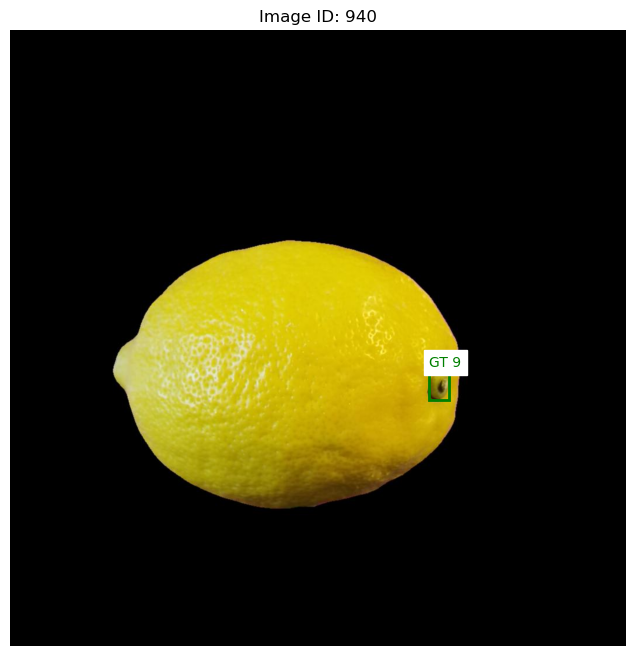

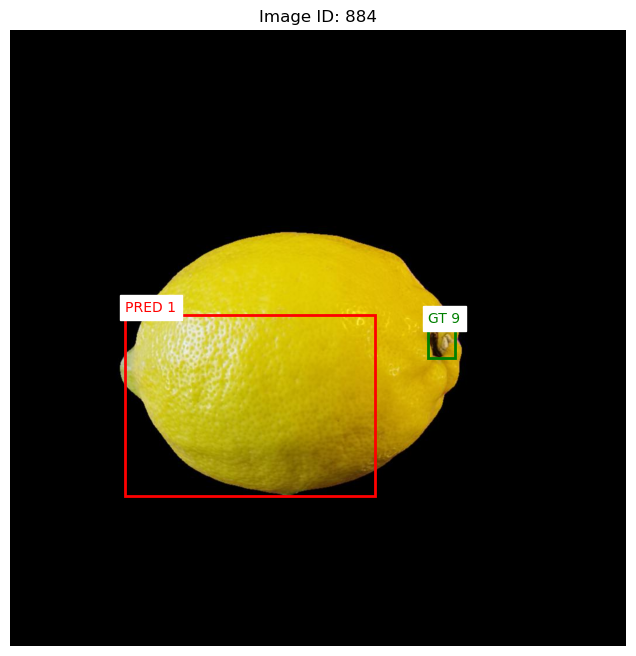

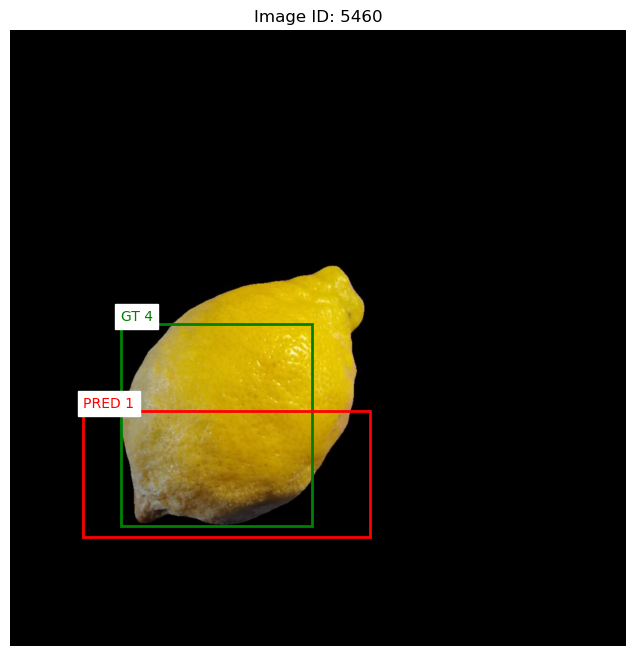

In [168]:
test_dataset = LemonCocoDataset(
    root_dir="lemon_local_test/images",  
    annotation_file="lemon_local_test/annotations.json",
    transforms=T.ToTensor()
)


model.eval()


num_samples = 3
indices = random.sample(range(len(test_dataset)), num_samples)

def draw_boxes(ax, boxes, labels, color, label_prefix=""):
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        if labels is not None:
            ax.text(x1, y1 - 5, f"{label_prefix}{labels[i]}", color=color, fontsize=10, backgroundcolor="white")

# === Visualize predictions
for idx in indices:
    image, target = test_dataset[idx]
    img_np = image.permute(1, 2, 0).numpy()
    image_id = target["image_id"].item()

    with torch.no_grad():
        prediction = model([image.to(device)])[0]

    # Filter predictions by score
    score_threshold = 0.67
    keep = prediction["scores"] >= score_threshold
    pred_boxes = prediction["boxes"][keep].cpu().numpy()
    pred_labels = prediction["labels"][keep].cpu().numpy()

    # Ground truth
    gt_boxes = target["boxes"].cpu().numpy()
    gt_labels = target["labels"].cpu().numpy()

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img_np)
    draw_boxes(ax, gt_boxes, gt_labels, "green", label_prefix="GT ")
    draw_boxes(ax, pred_boxes, pred_labels, "red", label_prefix="PRED ")
    ax.set_title(f"Image ID: {image_id}")
    plt.axis('off')
    plt.show()

Look at mould specifically

* Found 49 test samples with mould.


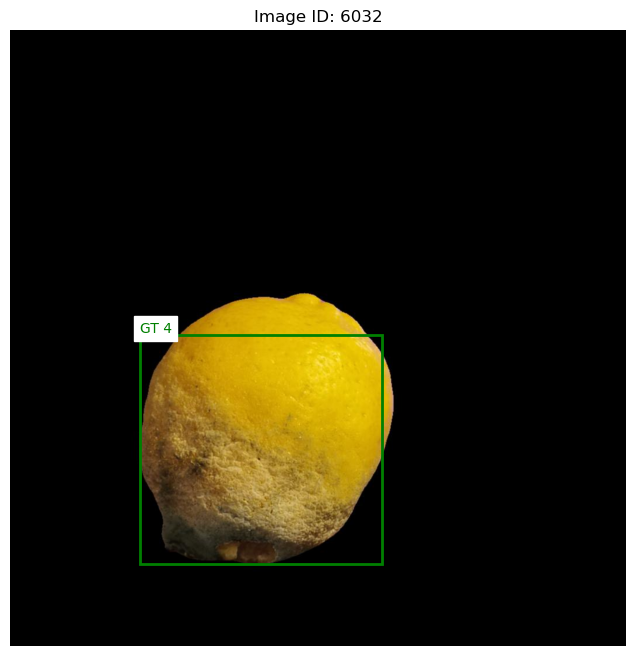

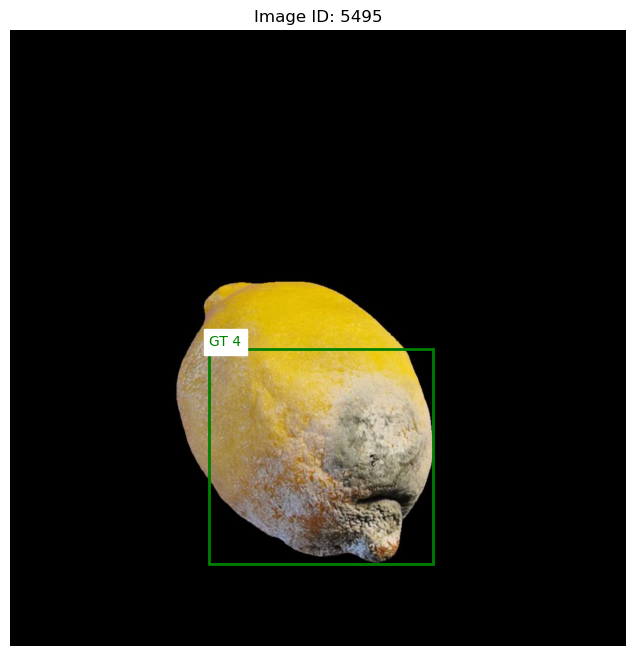

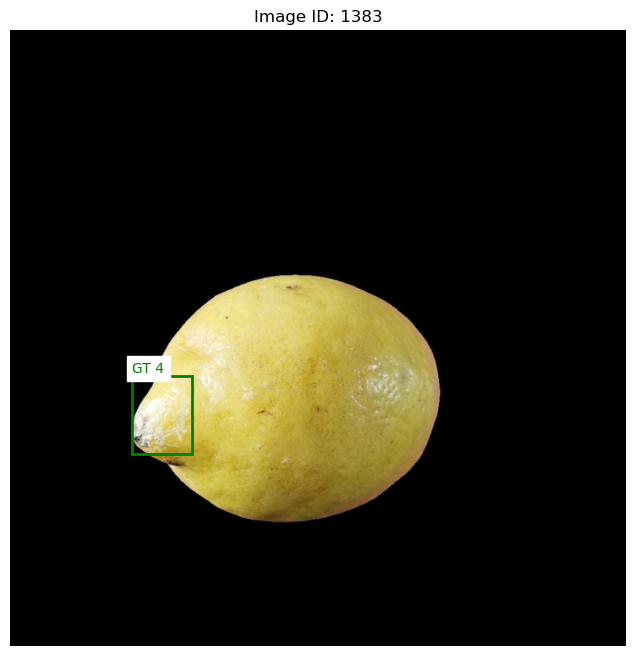

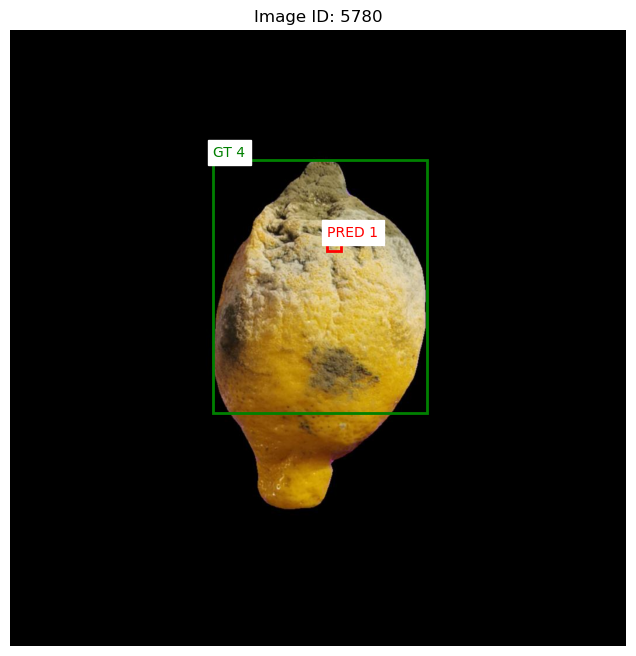

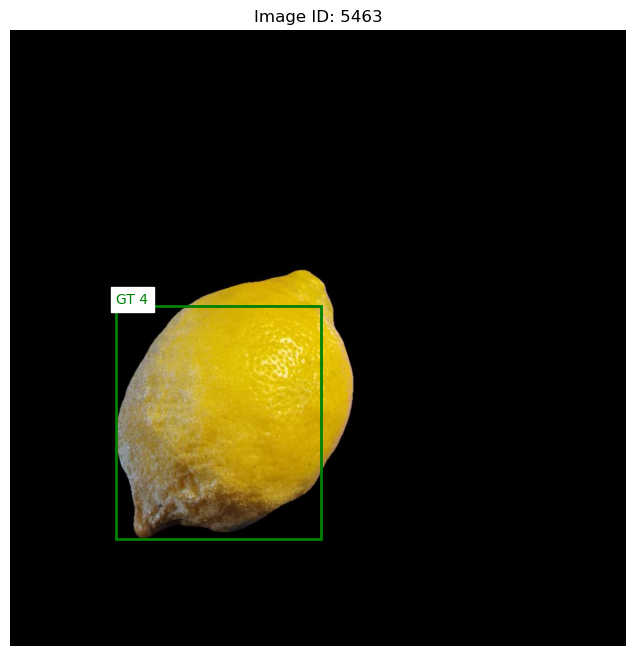

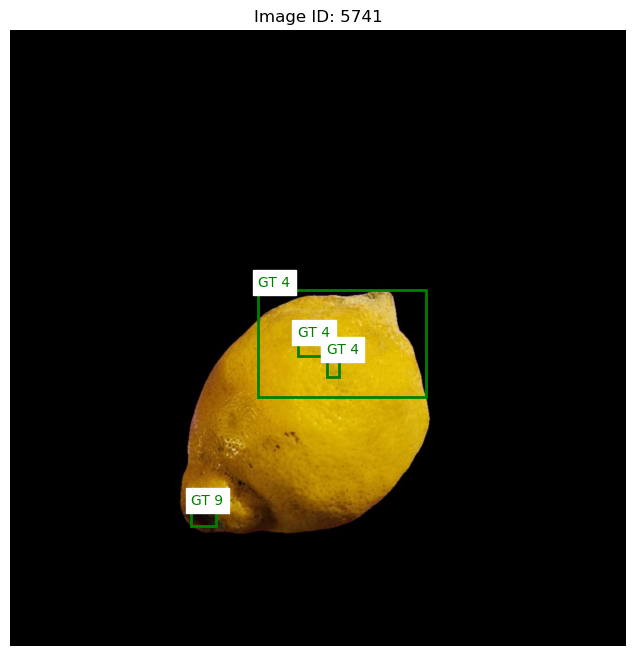

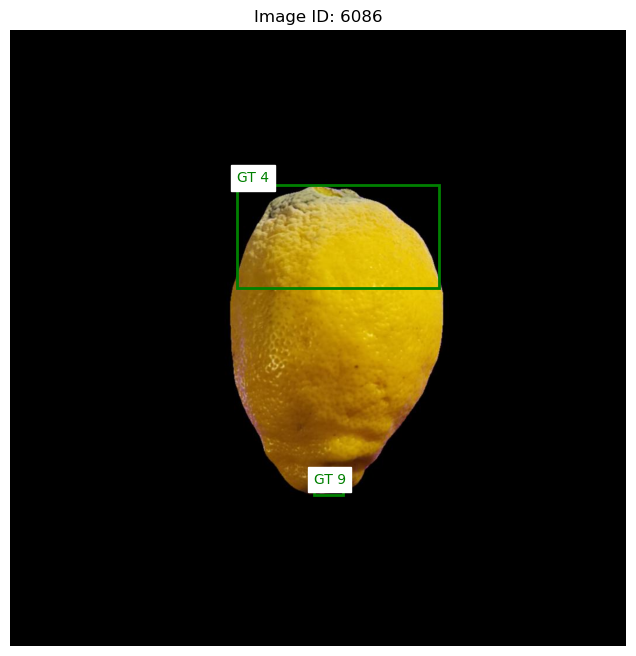

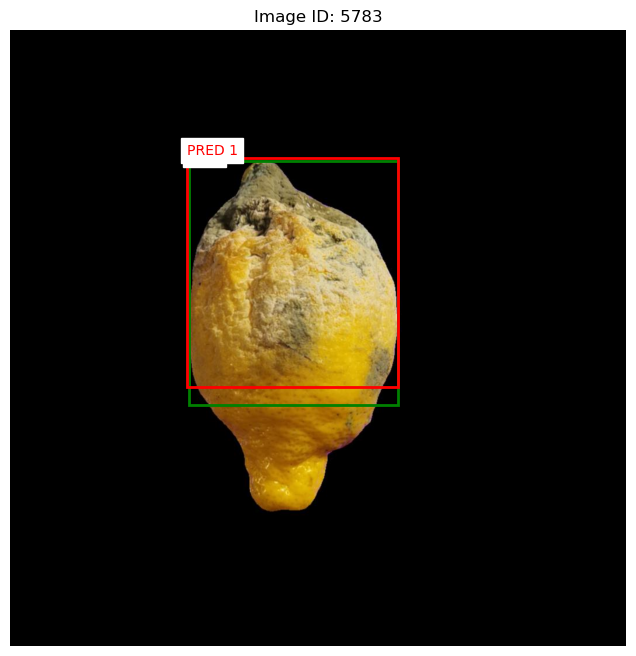

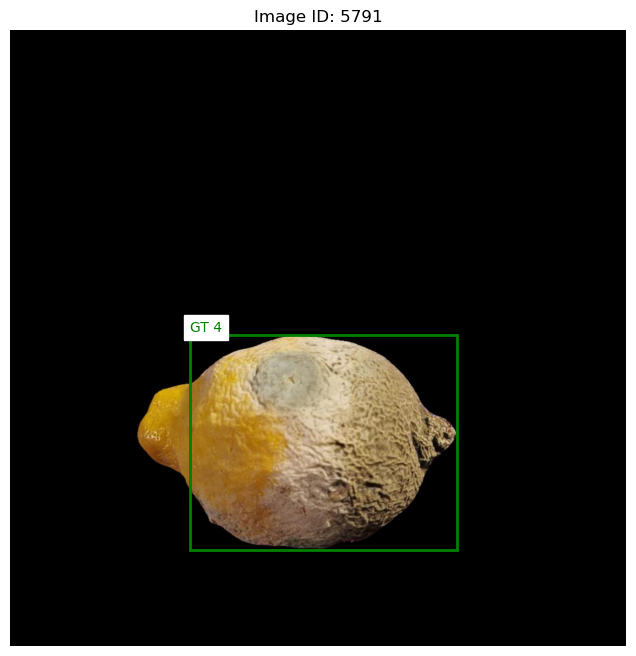

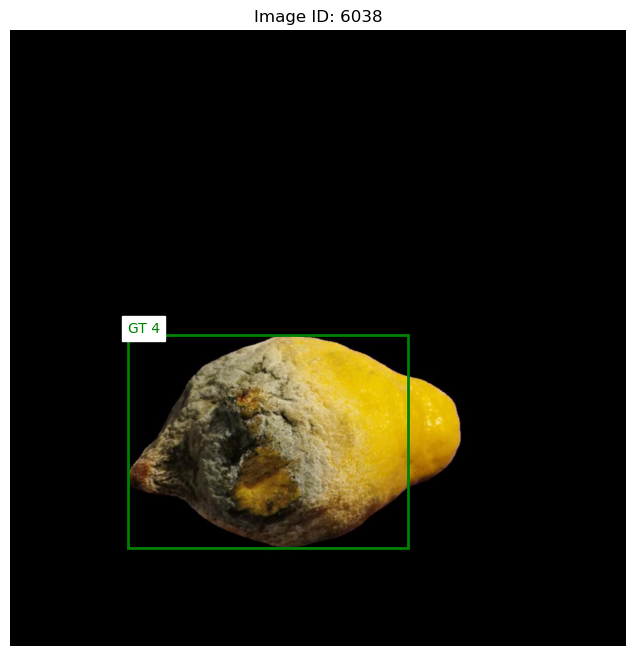

In [166]:
# === Load test dataset
test_dataset = LemonCocoDataset(
    root_dir="lemon_local_test/images",
    annotation_file="lemon_local_test/annotations.json",
    transforms=T.ToTensor()
)

# === Filter to samples that contain 'mould' (category_id = 0)
mould_indices = []
for i in range(len(test_dataset)):
    _, target = test_dataset[i]
    if 4 in target["labels"].tolist():  # 0 is mould after reindexing
        mould_indices.append(i)

print(f"* Found {len(mould_indices)} test samples with mould.")


num_samples = min(10, len(mould_indices))
indices = random.sample(mould_indices, num_samples)


model.eval()

# === Visualization helper
def draw_boxes(ax, boxes, labels, color, label_prefix=""):
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        if labels is not None:
            ax.text(x1, y1 - 5, f"{label_prefix}{labels[i]}", color=color, fontsize=10, backgroundcolor="white")


for idx in indices:
    image, target = test_dataset[idx]
    img_np = image.permute(1, 2, 0).numpy()
    image_id = target["image_id"].item()

    with torch.no_grad():
        prediction = model([image.to(device)])[0]

    # Filter predictions by score
    score_threshold = 0.68
    keep = prediction["scores"] >= score_threshold
    pred_boxes = prediction["boxes"][keep].cpu().numpy()
    pred_labels = prediction["labels"][keep].cpu().numpy()

    # Ground truth
    gt_boxes = target["boxes"].cpu().numpy()
    gt_labels = target["labels"].cpu().numpy()

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img_np)
    draw_boxes(ax, gt_boxes, gt_labels, "green", label_prefix="GT ")
    draw_boxes(ax, pred_boxes, pred_labels, "red", label_prefix="PRED ")
    ax.set_title(f"Image ID: {image_id}")
    plt.axis('off')
    plt.show()